# <font color="blue"> Final Project - Emotion Detection </font>



#### Submitted by: Inbal Mishal  & Tal Levi 

In [849]:
# load the libraries
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from ipywebrtc import AudioRecorder, CameraStream
import torchaudio
from IPython.display import Audio

from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

_________________________________________________________________________

### Part 1: preprocessing the csv DB

In [850]:
# Global params:
csv_section1_path = "IEMOCAP_csv\\df_iemocap_1.csv"

# The name of the files folder. all the files were in the same folder. 
# This folder was in the same folder of the notebook file.
old_wav_db_name = "wav_db"

# This is the name of the new DB that we will create.
new_wav_db_name = "tidy_wav_db"

IEMOCAP is a DB of wav files and their label.
The labels are different emotions: anger, happiness, excitement, sadness, frustration, fear, surprise, neutral, disappointment, other (other emotions) and XXX (no emotion).
<br>This DB labels comes in 5 different csv files. In order to connect between these files, clean the DB and devide the files into folders according to their category we created some functions (you can see these functions after this cell).
<br>After research and several attempts, we noticed that is difficult to the model to learn when there are many categories and a small number of examples. <br>As a result we chose to focus on the categories: anger, sadness and neutral. 

In [851]:
# Connect between all of the csv files into one data frame and download it
def get_csv_db(file_path_of_one_csv_file):
    
    data_dir = pathlib.Path('connected_db')
    
    if not data_dir.exists():
    
        for i in range(1, 6):
            # Get the file_path of one of the csv files
            file_path = list(file_path_of_one_csv_file)
            file_path[-5] = str(i)
            file_path = "".join(file_path)

            # Read the current file
            df_i = pd.read_csv(file_path, delimiter=',')

            # Connect between the files
            if(i==1):
                final_df = df_i
            else:
                final_df = pd.concat([final_df, df_i], ignore_index=True)

             # Add duration column to the db
            duration = final_df.loc[:, "end_time"] - final_df.loc[:, "start_time"]
            final_df['duration'] = duration
            
            # Download the connected db
            final_df.to_csv(r'connected_db.csv', index=False, header=True)
    else:
            final_df = pd.read_csv('connected_db.csv', delimiter=',')

    return final_df

In [852]:
# Returns clean db with relevant categories and relevant columns and download it
def get_clean_db():
    # Create csv file of the whole db
    data_dir = pathlib.Path('final_db_csv')
    
    if not data_dir.exists():
        
        # Download and get the csv db
        df = get_csv_db(csv_section1_path)
        
        # Delete irrelevant columns
        df.drop('start_time', inplace=True, axis=1)
        df.drop('end_time', inplace=True, axis=1)
        df.drop('val', inplace=True, axis=1)
        df.drop('act', inplace=True, axis=1)
        df.drop('dom', inplace=True, axis=1)

        # Delete non-relevant categories
        indexes = df[(df['emotion'] == 'xxx') | (df['emotion'] == 'oth') | (df['emotion'] == 'dis')
                     | (df['emotion'] == 'fea') | (df['emotion'] == 'sur') | (df['emotion'] == 'hap')
                     |(df['emotion'] == 'exc')|(df['emotion'] == 'fru')].index
        df.drop(indexes, inplace=True)
        
        # Ddd '.wav' to the wav files
        df['wav_file'] = df['wav_file'].astype(str) + '.wav'
        
        # Create csv file of the db with the paths
        df.to_csv(r'final_db_csv.csv', index=False, header=True)
            
    else:
        df = pd.read_csv('final_db_csv', delimiter=',')

    return df

In [853]:
# Clean the df by range of duration
def clean_db_by_duration(df, min, max):
    bigger_than_min = min<df["duration"]
    smaller_than_max = df["duration"]<max
    
    result_bool = bigger_than_min & smaller_than_max
    
    new_df = df[result_bool.values]
    
    return new_df

In [854]:
# Clean X recordings of the chosen emotion
def delete_shortest_recordings(df, emotion, x):
    emo_bool = df["emotion"] == emotion
    df_emotion = df[emo_bool.values]    
    df_emotion = df_emotion.sort_values(by=["duration"])
    new_df = df.copy()
    
    for i,idx in enumerate(df_emotion.index):
        if i<x:
            new_df.drop([idx], inplace=True)
        else:
            break
    return new_df

In [855]:
# Clean target_dir
def clean_target_dir(target_dir):
    files_target_dir = os.listdir(target_dir)
    for filename in files_target_dir:
        file_path = os.path.join(target_dir, filename)
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    
# Create relevant folders
def create_relevant_folders(target_dir, folder_names):
    for folder_name in folder_names:
        # Create target Directory
        tar_dir = os.path.join(target_dir, folder_name)
        os.mkdir(tar_dir)

# Copy the wav files into other path according to their classefication
def move_wav_files_path(source_dir, target_dir, df):
#     clean_target_dir(target_dir)
    data_dir = pathlib.Path(target_dir)
    if not data_dir.exists():
        os.mkdir(target_dir)
    
        categories = get_categories(df)
        create_relevant_folders(target_dir, categories) 

        file_names = list(df.index)

        for file_name in file_names:
            target_folder_dir = os.path.join(target_dir,  df.loc[file_name, "emotion"])
            current_file_dir = os.path.join(source_dir, file_name)
            shutil.copy(current_file_dir, target_folder_dir)

In [856]:
# Returns list of the categories in the db
def get_categories(df_csv):
    return list(df_csv.loc[:, "emotion"].drop_duplicates())

# Returns the size of the db
def get_db_size(df_csv):
    return len(df_csv.index)

In [857]:
# Returns the paths of the files in the data frame
def get_wav_file_paths(df):
    file_paths = []
    for file_name in df.index:
        emotion = df.loc[file_name, "emotion"]
        path = os.path.join(new_wav_db_name, emotion, file_name)
        file_paths.append(path)
    return file_paths

In [858]:
# Checks how many time emotion appear in the db
def count_emotion(df, em_name):
    count = 0
    for i in df['emotion']:
        if i==em_name:
            count+=1
    return count

____________

In [859]:
# Create tidy dataFrame
df = get_clean_db()
df = df.set_index("wav_file") # we use it in some functions. it is a global param
df

,emotion,duration
wav_file,,
Ses01F_impro04_F000.wav,neu,4.3945
Ses01F_impro04_F001.wav,neu,4.4052
Ses01F_impro04_F005.wav,neu,2.4096
Ses01F_impro04_F006.wav,neu,3.5565
Ses01F_impro04_F009.wav,neu,1.3837
...,...,...
Ses05M_impro02_M024.wav,sad,3.1900
Ses05M_impro02_M025.wav,sad,9.3800
Ses05M_impro02_M027.wav,sad,1.9200


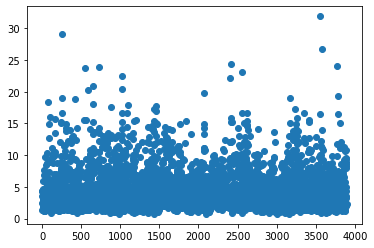

In [860]:
# Draw distribution graph according to the duration
y = list(df["duration"])
x = np.arange(start =0, stop = len(df["duration"]),step = 1)

plt.scatter(x, y)
plt.show()

Here, we can see that our data is not balanced.In order to get a better data, we clean it by the duration of the wave files.

In [861]:
# Clean the recordings below 2 seconds over 7 seconds
df = clean_db_by_duration(df, 2, 7)
df

,emotion,duration
wav_file,,
Ses01F_impro04_F000.wav,neu,4.3945
Ses01F_impro04_F001.wav,neu,4.4052
Ses01F_impro04_F005.wav,neu,2.4096
Ses01F_impro04_F006.wav,neu,3.5565
Ses01F_impro04_F013.wav,neu,4.2369
...,...,...
Ses05M_impro02_M019.wav,sad,4.4100
Ses05M_impro02_M021.wav,sad,3.5700
Ses05M_impro02_M023.wav,sad,4.9100


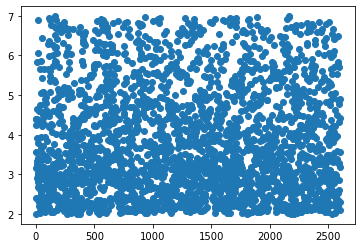

In [862]:
# Draw distribution graph according to the duration

y = list(df["duration"])
x = np.arange(start =0, stop = len(df["duration"]),step = 1)

plt.scatter(x, y)
plt.show()

In [863]:
ang_count = count_emotion(df, "ang")
print('ang = ', ang_count)

neu_count = count_emotion(df, "neu")
print('neu = ', neu_count)

sad_count = count_emotion(df, "sad")
print('sad = ', sad_count)

min_count = min([ang_count, neu_count, sad_count])
print('min_count = ', min_count)

ang =  772
neu =  1135
sad =  694
min_count =  694


In [864]:
# Get a balanced DB
df = delete_shortest_recordings(df, "ang", (ang_count-min_count))
df = delete_shortest_recordings(df, "neu", (neu_count-min_count))
df = delete_shortest_recordings(df, "sad", (sad_count-min_count))

df

,emotion,duration
wav_file,,
Ses01F_impro04_F000.wav,neu,4.3945
Ses01F_impro04_F001.wav,neu,4.4052
Ses01F_impro04_F006.wav,neu,3.5565
Ses01F_impro04_F013.wav,neu,4.2369
Ses01F_impro04_F029.wav,ang,3.1600
...,...,...
Ses05M_impro02_M019.wav,sad,4.4100
Ses05M_impro02_M021.wav,sad,3.5700
Ses05M_impro02_M023.wav,sad,4.9100


In [865]:
print('ang = ', count_emotion(df, "ang"))
print('neu = ', count_emotion(df, "neu"))
print('sad = ', count_emotion(df, "sad"))

ang =  694
neu =  694
sad =  694


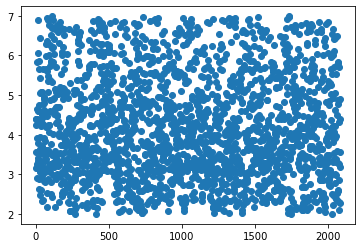

In [866]:
# Draw distribution graph according to the duration
y = list(df["duration"])
x = np.arange(start =0, stop = len(df["duration"]),step = 1)

plt.scatter(x, y)
plt.show()

In [867]:
# Create a tidy presentation of the relevant db
move_wav_files_path(old_wav_db_name, new_wav_db_name, df)

In [868]:
DATASET_SIZE = get_db_size(df)
categories = get_categories(df)
print("DATASET_SIZE = ", DATASET_SIZE)
print("categories = ", categories)

DATASET_SIZE =  2082
categories =  ['neu', 'ang', 'sad']


In [869]:
# Get all file_paths
import random
file_paths = get_wav_file_paths(df)
random.shuffle(file_paths)

__________________

### Part 2: Preprocessing the csv DB to get spectrogram DB

Here, you can see some functions that helped us in getting the spectrogram DB.

In [870]:
# Returns the wav file path
def get_wav_file_path(df, file_name):
    emotion = df.loc[file_name, "emotion"]
    path = os.path.join(new_wav_db_name, emotion, file_name)
    return path

In [871]:
# Get the file_path and returns a waveform
def get_waveform(file_path):

    # Read the wav file as a binary audio
    audio_binary = tf.io.read_file(file_path)
    
    # Decode the binary audio to waveform and normalize the values to the range [-1.0, 1.0]    
    audio, _ = tf.audio.decode_wav(audio_binary)
    
    # Delete dimensions that equal to 1 and return the result
    return tf.squeeze(audio, axis=-1)

In [872]:
# Get the file_path and return the label
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

In [873]:
# Get the file_path and return the waveform and it's label
def get_waveform_and_label(file_path):
    # Get the waveform
    waveform = get_waveform(file_path)
    
    # Get the label
    label = get_label(file_path)
    
    return waveform, label

In [875]:
# Returns shuffled DB of waveforms and their labels
def get_waveforms_labeled_db(files_paths):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    files_ds = tf.data.Dataset.from_tensor_slices(files_paths)
    waveform_ds = files_ds.map(get_waveform_and_label,
                               num_parallel_calls=AUTOTUNE)
    return waveform_ds

In [877]:
size_of_pad = int(df["duration"].max()*16000)+1

# Returns the spectrogram of the waveform
def get_spectrogram(waveform):
    # Padding for files with less than size_of_pad samples
    zero_padding = tf.ones([size_of_pad] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [878]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    np.seterr(divide = 'ignore')
    log_spec = np.log(spectrogram.T)
    np.seterr(divide = 'warn')
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [879]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == categories)
    return spectrogram, label_id

In [880]:
# Returns DB of spectrograms and their labels
def get_spectrograms_labeled_db(waveform_ds):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    spectrogram_ds = waveform_ds.map(
        get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return spectrogram_ds

In [881]:
# Split the DB to test, train and validation
def split(full_dataset):
    train_size = int(0.6 * DATASET_SIZE)
    val_size = int(0.15 * DATASET_SIZE)
    test_size = DATASET_SIZE - train_size - val_size # and 25% for the test

    train_dataset = full_dataset.take(train_size)
    no_train_dataset = full_dataset.skip(train_size)
    val_dataset = no_train_dataset.take(val_size)
    test_dataset = no_train_dataset.skip(val_size)

    return train_dataset, train_size, val_dataset, val_size, test_dataset, test_size

_____________________________

In [882]:
# Just for example:
path = get_wav_file_path(df, "Ses01F_impro04_F000.wav")
waveform = get_waveform(path)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Audio playback


In [883]:
# Just for example:
waveform, label = get_waveform_and_label(path)
print("label:\n", label.numpy().decode('utf-8'))
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

label:
 neu
Audio playback


In [884]:
# Just for example - create the waveform_ds of all of the files
waveform_ds = get_waveforms_labeled_db(file_paths)
print(waveform_ds)
print("------------------------------------------------Done------------------------------------------------")

<ParallelMapDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>
------------------------------------------------Done------------------------------------------------


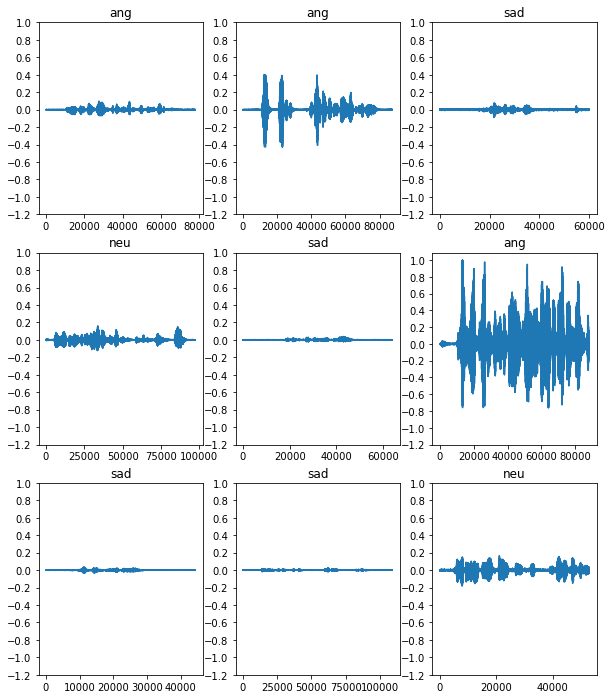

In [885]:
# Just for example:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

In [886]:
# Just for example:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: ang
Waveform shape: (77920,)
Spectrogram shape: (872, 129)
Audio playback


<ipython-input-878-af892ab9ec1a>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


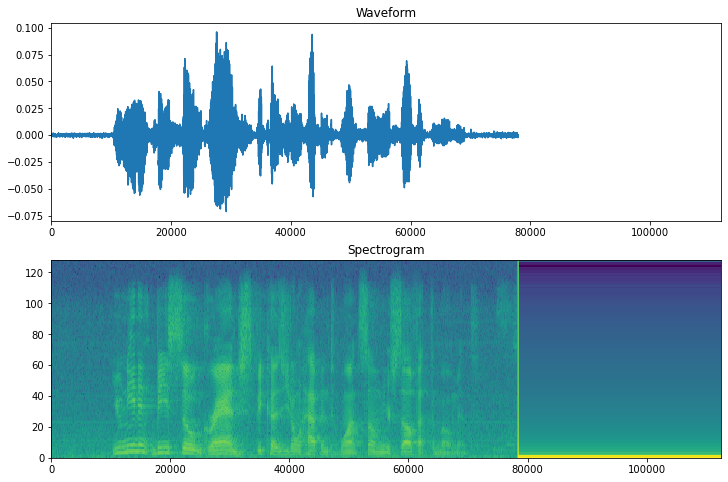

In [887]:
# Just for example:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, size_of_pad])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [888]:
# Just for example - create the spectrogram_ds of all of the files
spectrogram_ds = get_spectrograms_labeled_db(waveform_ds)
print(spectrogram_ds)
print("------------------------------------------------Done------------------------------------------------")

<ParallelMapDataset shapes: ((None, 129, 1), ()), types: (tf.float32, tf.int64)>
------------------------------------------------Done------------------------------------------------


<ipython-input-878-af892ab9ec1a>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


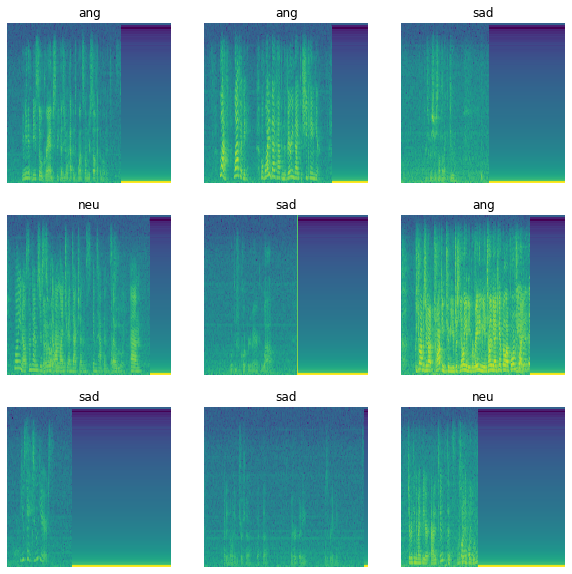

In [889]:
# Just for example:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(categories[label_id.numpy()])
    ax.axis('off')

plt.show()

________

## split to train, validation and test

In [890]:
# Split the files to train, validation and test
train_size = int(0.6 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
# = 25% for the test

train_files = file_paths[:train_size]
val_files = file_paths[train_size: train_size + val_size]
test_files = file_paths[train_size + val_size:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1249
Validation set size 312
Test set size 521


In [891]:
# Create the training set
train_waveform_ds = get_waveforms_labeled_db(train_files)
train_ds = get_spectrograms_labeled_db(train_waveform_ds)

In [892]:
# Create the validation set
val_waveform_ds = get_waveforms_labeled_db(val_files)
val_ds = get_spectrograms_labeled_db(val_waveform_ds)

In [893]:
# Create the test set
test_waveform_ds = get_waveforms_labeled_db(test_files)
test_ds = get_spectrograms_labeled_db(test_waveform_ds)

______

### Build the model:

In [894]:
batch_size = 32

# Combines consecutive elements of this dataset into batches.
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [895]:
# Add dataset cache() and prefetch() operations to reduce read latency while training the model.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [896]:
# Create the model 
for spectrogram, label in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
    print('Input shape:', input_shape)
num_labels = len(categories)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential()

model.add(layers.Input(shape=input_shape))

model.add(preprocessing.Resizing(100, 100))
model.add(norm_layer)

model.add(Conv2D(16, (12, 16), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(24, (8, 12), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(24, (5, 7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation="softmax"))
model.summary()

Input shape: (872, 129, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_12 (Resizing)       (None, 100, 100, 1)       0         
_________________________________________________________________
normalization_12 (Normalizat (None, 100, 100, 1)       3         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 100, 100, 16)      3088      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 50, 50, 24)        36888     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 25, 25, 24)        0         
_________________________________________________________________
conv2d_38 (Conv2D)        

In [897]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [898]:
# Fit the model
EPOCHS = 20
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
)

Epoch 1/20


E:\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


40/40 [==============================] - 45s 981ms/step - loss: 0.9260 - accuracy: 0.5324 - val_loss: 0.8876 - val_accuracy: 0.5801
Epoch 2/20
40/40 [==============================] - 33s 832ms/step - loss: 0.7872 - accuracy: 0.6133 - val_loss: 0.7708 - val_accuracy: 0.6090
Epoch 3/20
40/40 [==============================] - 33s 819ms/step - loss: 0.7249 - accuracy: 0.6397 - val_loss: 0.7397 - val_accuracy: 0.6218
Epoch 4/20
40/40 [==============================] - 33s 823ms/step - loss: 0.7173 - accuracy: 0.6717 - val_loss: 0.7318 - val_accuracy: 0.6218
Epoch 5/20
40/40 [==============================] - 33s 823ms/step - loss: 0.7172 - accuracy: 0.6733 - val_loss: 0.6873 - val_accuracy: 0.6378
Epoch 6/20
40/40 [==============================] - 33s 830ms/step - loss: 0.6942 - accuracy: 0.6613 - val_loss: 0.6694 - val_accuracy: 0.6763
Epoch 7/20
40/40 [==============================] - 33s 823ms/step - loss: 0.6668 - accuracy: 0.6894 - val_loss: 0.6449 - val_accuracy: 0.6923
Epoch 8/20

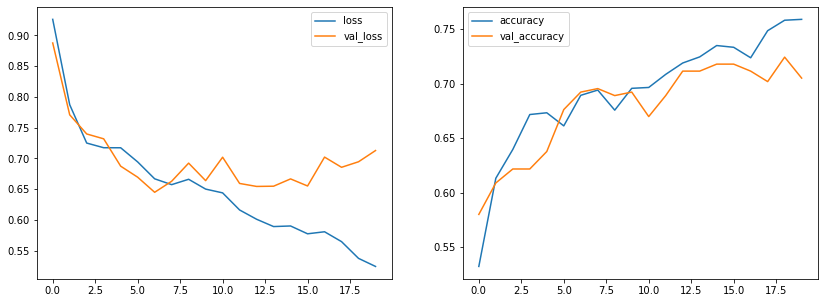

In [899]:
# Watch the loss and accuracy graphs
metrics = history.history
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [900]:
test_audio = []
test_labels = []
for audio, label in test_ds: 
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
    
test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [901]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 73%


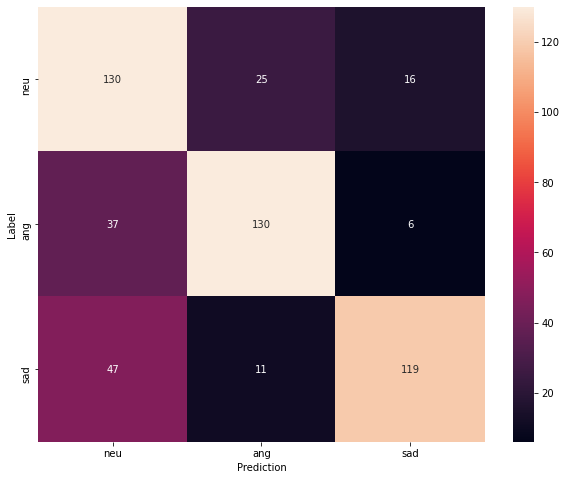

In [902]:
# Final result:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=categories, yticklabels=categories, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()